# Выпускной проект: Выявление профилей потребления

## Предобработка данных

In [ ]:
import pandas as pd                                         
import numpy as np                                         
import math as mth                                          
import seaborn as sns                                      
import matplotlib.pyplot as plt                             
import plotly.express as px                               
%matplotlib inline
import datetime as dt   
import scipy.stats as stats
from scipy import stats as st 
from sklearn.cluster import DBSCAN
from datetime import timedelta
from scipy.stats import shapiro
sns.set(rc={'figure.figsize':(12, 7)})
import plotly.express as px
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import StandardScaler            # для стандартизации данных
from sklearn.cluster import KMeans                          # K-Means кластеризация
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage 

In [ ]:
google_id = "1DkqEQWZoHh22YrsYcNUxSzlhgFqdl0tf"
df = pd.read_csv(f"https://drive.google.com/uc?export=download&id={google_id}" )

In [ ]:
df.head(5)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


In [ ]:
df.isnull().sum() # пропусков не обнаружено

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

In [ ]:
df.duplicated().sum() # явных дубликатов нет

0

In [ ]:
df['revenue'] = df['price'] * df['quantity']

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
df['date']

0      2018-10-01 00:00:00
1      2018-10-01 00:00:00
2      2018-10-01 00:00:00
3      2018-10-01 00:00:00
4      2018-10-01 00:00:00
5      2018-10-01 00:00:00
6      2018-10-01 00:00:00
7      2018-10-01 08:00:00
8      2018-10-01 08:00:00
9      2018-10-01 09:00:00
10     2018-10-01 11:00:00
11     2018-10-01 12:00:00
12     2018-10-01 13:00:00
13     2018-10-01 15:00:00
14     2018-10-01 16:00:00
15     2018-10-01 18:00:00
16     2018-10-01 18:00:00
17     2018-10-01 18:00:00
18     2018-10-01 18:00:00
19     2018-10-01 21:00:00
20     2018-10-02 08:00:00
21     2018-10-02 10:00:00
22     2018-10-02 11:00:00
23     2018-10-02 11:00:00
24     2018-10-02 11:00:00
25     2018-10-02 11:00:00
26     2018-10-02 11:00:00
27     2018-10-02 11:00:00
28     2018-10-02 11:00:00
29     2018-10-02 11:00:00
30     2018-10-02 11:00:00
31     2018-10-02 11:00:00
32     2018-10-02 11:00:00
33     2018-10-02 11:00:00
34     2018-10-02 11:00:00
35     2018-10-02 11:00:00
36     2018-10-02 11:00:00
3

In [ ]:
# также создадим столбцы с месяцем,днем недели и датой без времени
df['date_no_time'] = pd.to_datetime(df['date'].dt.date)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.dayofweek
df['week'] = df['date'].dt.isocalendar().week
df['hour'] = df['date'].dt.hour
df.sample(10)

,date,customer_id,order_id,product,quantity,price,revenue,date_no_time,year,month,day,week,hour
1906,2019-02-19 14:00:00,353d3da0-5399-4939-a860-a0e0849446dc,70353,"Коврик придверный влаговпитывающий Hello, Bonj...",1,1649.0,1649.0,2019-02-19,2019,2,1,8,14
1977,2019-02-23 18:00:00,533fc3fd-9412-49d4-90f5-fd9301dc48b9,14547,Рассада зелени для кухни Шалфея в горшке диам....,1,120.0,120.0,2019-02-23,2019,2,5,8,18
5172,2019-06-12 17:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Огурца сорт Каролина кассета 6 шт E6,1,120.0,120.0,2019-06-12,2019,6,2,24,17
7266,2020-01-07 17:00:00,6b100fab-a3c5-4f64-82c9-4d519f85cb5d,102201,томата (помидор) Исуповский №37 сорт индетерми...,2,38.0,76.0,2020-01-07,2020,1,1,2,17
7308,2020-01-12 19:00:00,3dc5b972-ff3f-4e6d-a76e-5f47530a2f7c,107790,"Незабудка смесь 0,1 г 4650091480340",1,10.0,10.0,2020-01-12,2020,1,6,2,19
6452,2019-09-28 14:00:00,f55afa87-4427-498e-9015-a6c5a76e4976,14937,Пеларгония зональная диам. 12 см ярко розовая ...,1,150.0,150.0,2019-09-28,2019,9,5,39,14
6633,2019-10-16 18:00:00,8a2f2c40-48a4-4e6c-8a65-64e692ad1b2a,72926,Полки QWERTY Токио чёрный 30х30х10 см 25х25х10...,1,1500.0,1500.0,2019-10-16,2019,10,2,42,18
7108,2019-12-21 16:00:00,27af07b7-f715-4ff3-b82c-29ce55be5ca8,107878,Рассада Капусты белокачанная поздняя сорт Коло...,1,195.0,195.0,2019-12-21,2019,12,5,51,16
1166,2018-12-11 08:00:00,c9f5dffa-0601-40d8-b690-8963a70ab521,69297,Пресс для чеснока Attribute WESTERN AGW050,1,202.0,202.0,2018-12-11,2018,12,1,50,8
1502,2019-01-13 11:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,Пеларгония зональная диам. 12 см темнорозовая ...,1,188.0,188.0,2019-01-13,2019,1,6,2,11


In [ ]:
df['product'] = df['product'].str.lower()
df['product'] = df['product'].str.replace('ё','е', regex=True)

In [ ]:
print(df.duplicated(subset = ['order_id','product','customer_id']).sum()) # получилось 1886 неявных дубликатов

1886


In [ ]:
duplicated = df[df.duplicated(subset = ['order_id','product','customer_id'],keep = False)]
duplicated.tail(5)

,date,customer_id,order_id,product,quantity,price,revenue,date_no_time,year,month,day,week,hour
6716,2019-10-30 07:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"таз пластмассовый со стиральной доской (иж), 1...",1,397.0,397.0,2019-10-30,2019,10,2,44,7
6717,2019-10-30 09:00:00,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,сумка-тележка 2-х колесная gimi argo синяя,1,1087.0,1087.0,2019-10-30,2019,10,2,44,9
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"таз пластмассовый со стиральной доской (иж), 1...",1,397.0,397.0,2019-10-31,2019,10,3,44,0
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"таз пластмассовый со стиральной доской (иж), 1...",1,397.0,397.0,2019-10-31,2019,10,3,44,2
6736,2019-10-31 16:00:00,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,сумка-тележка 2-х колесная gimi argo синяя,1,1087.0,1087.0,2019-10-31,2019,10,3,44,16


принимаю решение их удалить, так как это может существенно исказить общую картирну + данные предоставил заказчик(возможны ошибки в самих данных)

In [ ]:
df = df.drop_duplicates(['product', 'customer_id', 'order_id'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5588 entries, 0 to 7473
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          5588 non-null   datetime64[ns]
 1   customer_id   5588 non-null   object        
 2   order_id      5588 non-null   int64         
 3   product       5588 non-null   object        
 4   quantity      5588 non-null   int64         
 5   price         5588 non-null   float64       
 6   revenue       5588 non-null   float64       
 7   date_no_time  5588 non-null   datetime64[ns]
 8   year          5588 non-null   int64         
 9   month         5588 non-null   int64         
 10  day           5588 non-null   int64         
 11  week          5588 non-null   UInt32        
 12  hour          5588 non-null   int64         
dtypes: UInt32(1), datetime64[ns](2), float64(2), int64(6), object(2)
memory usage: 594.8+ KB


In [ ]:
np.percentile(df['quantity'], [95,99])

array([ 6., 30.])

In [ ]:
np.percentile(df['revenue'], [95,99])

array([2849.65, 6149.  ])

В не менее, чем 95% строках, количество заказанных единиц не более 6.
В не менее, чем 95% строках, стоимость не более 2849 р.

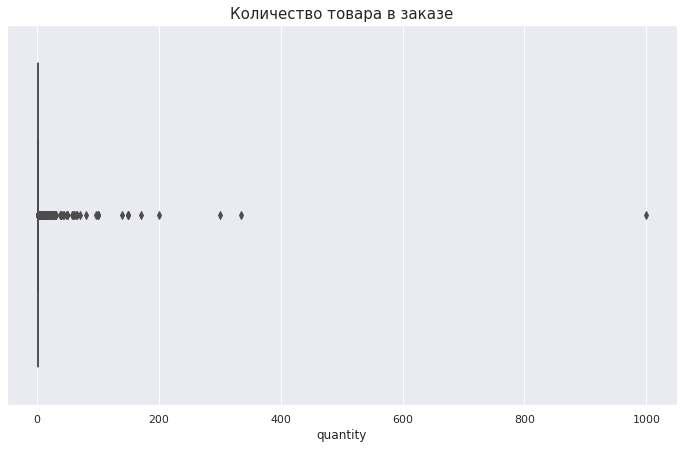

In [ ]:
sns.boxplot(x='quantity', data=df)
plt.title('Количество товара в заказе', fontsize=15)
plt.show()

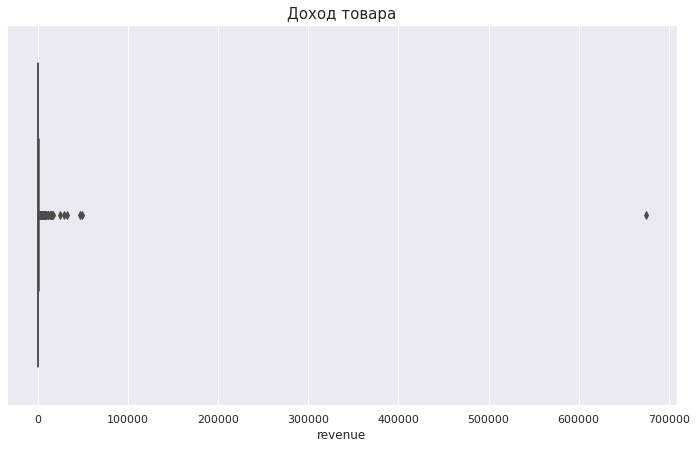

In [ ]:
sns.boxplot(x='revenue', data=df)
plt.title('Доход товара', fontsize=15)
plt.show()

на обоих графиках наблюдаем аномальные одиночные выбросы, принимаем решение их удалить

In [ ]:
upper_quantity = df['quantity'].quantile(.99) 
upper_revenue = df['revenue'].quantile(.99)

In [ ]:
df = df[(df['quantity'] < upper_quantity)]
df = df[(df['revenue'] < upper_revenue)]

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_id,5483.0,55709.870874,32566.306071,12624.0,14804.0,69177.0,71927.0,112789.0
quantity,5483.0,1.707277,2.525650,1.0,1.0,1.0,1.0,29.0
price,5483.0,493.999650,821.310097,9.0,90.0,150.0,524.0,6134.0
revenue,5483.0,588.458219,900.447362,9.0,120.0,188.0,689.0,6148.0
year,5483.0,2018.829291,0.488880,2018.0,2019.0,2019.0,2019.0,2020.0
month,5483.0,6.666423,3.602993,1.0,4.0,6.0,10.0,12.0
day,5483.0,2.725150,1.976088,0.0,1.0,3.0,4.0,6.0
week,5483.0,27.122378,15.637813,1.0,15.0,23.0,43.0,52.0
hour,5483.0,13.967536,4.957062,0.0,11.0,14.0,17.5,23.0


**Вывод**

На этапе предобработки данных мы:
- привели столбец с датой к чиатемому виду
- создали отдельные столбцы с месяцем и днем недели
- удалили неявные дубликаты, так как это могло повлиять на общую картину
- избавились от аномалий в столбцу quantity и revenue

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5483 entries, 0 to 7473
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          5483 non-null   datetime64[ns]
 1   customer_id   5483 non-null   object        
 2   order_id      5483 non-null   int64         
 3   product       5483 non-null   object        
 4   quantity      5483 non-null   int64         
 5   price         5483 non-null   float64       
 6   revenue       5483 non-null   float64       
 7   date_no_time  5483 non-null   datetime64[ns]
 8   year          5483 non-null   int64         
 9   month         5483 non-null   int64         
 10  day           5483 non-null   int64         
 11  week          5483 non-null   UInt32        
 12  hour          5483 non-null   int64         
dtypes: UInt32(1), datetime64[ns](2), float64(2), int64(6), object(2)
memory usage: 583.6+ KB


In [ ]:
order_customer_count = df.groupby('order_id')['customer_id'].nunique()
multi_customer_orders = order_customer_count[order_customer_count > 1]
multi_customer_order_ids = multi_customer_orders.index.tolist()

multi_customer_df = df[df['order_id'].isin(multi_customer_order_ids)]
multi_customer_df.head(10)

,date,customer_id,order_id,product,quantity,price,revenue,date_no_time,year,month,day,week,hour
512,2018-10-28 22:00:00,0b5ce2c7-acef-4a9a-b821-61a44ed05557,68785,"сиденье в ванну раздвижное, белый, св5, ника",1,374.0,374.0,2018-10-28,2018,10,6,43,22
538,2018-10-30 21:00:00,c1dd5c0e-51db-4a5d-91a3-5374cb20043d,68785,"сиденье в ванну раздвижное, белый, св5, ника",1,374.0,374.0,2018-10-30,2018,10,1,44,21
1154,2018-12-10 12:00:00,2f955596-4b13-432e-93f3-6433395aafe6,69283,сушилка для белья на батарею ника сб6-65 двухъ...,1,164.0,164.0,2018-12-10,2018,12,0,50,12
1160,2018-12-10 16:00:00,e3805ccd-2d64-4d0e-92dd-902293555c35,69283,сушилка для белья на батарею ника сб6-65 двухъ...,1,164.0,164.0,2018-12-10,2018,12,0,50,16
1177,2018-12-11 21:00:00,954172a5-634c-4a50-941d-9db6d15a7377,69310,"муляж груша желтый 9,5 см полиуретан",7,59.0,413.0,2018-12-11,2018,12,1,50,21
1196,2018-12-13 19:00:00,70d60304-4b3c-4f34-9430-1872ec6e6309,69345,сушилка для белья attribute прима 18 м синяя a...,1,974.0,974.0,2018-12-13,2018,12,3,50,19
1209,2018-12-15 07:00:00,22e4d79f-3613-4c22-8b01-7f880120bf5a,69345,сушилка для белья attribute прима 18 м синяя a...,1,974.0,974.0,2018-12-15,2018,12,5,50,7
1237,2018-12-17 14:00:00,4ea06f66-0876-4dec-8d14-ea994ffe435f,69410,муляж желудь 2 шт,3,22.0,66.0,2018-12-17,2018,12,0,51,14
1258,2018-12-18 20:00:00,caaa3f41-c9ab-4e3d-8b75-94e1d3a8d7b4,69410,муляж желудь 2 шт,3,22.0,66.0,2018-12-18,2018,12,1,51,20
1282,2018-12-20 16:00:00,5be0f4b4-947f-4672-b147-73ef5936ecd4,69485,набор столовых приборов 24 предмета saint germ...,1,1087.0,1087.0,2018-12-20,2018,12,3,51,16


похоже пользователи добавляли товар в корзину, но по каким то причинам не оплачивали покупки во время сессии на сайте, при следующем заходе на сайте они покупали тоже самое но у них уже был другой id.

Лучше удалим эти данные чтобы не портилась общая картина

In [ ]:
df.drop(multi_customer_df.index, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5423 entries, 0 to 7473
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          5423 non-null   datetime64[ns]
 1   customer_id   5423 non-null   object        
 2   order_id      5423 non-null   int64         
 3   product       5423 non-null   object        
 4   quantity      5423 non-null   int64         
 5   price         5423 non-null   float64       
 6   revenue       5423 non-null   float64       
 7   date_no_time  5423 non-null   datetime64[ns]
 8   year          5423 non-null   int64         
 9   month         5423 non-null   int64         
 10  day           5423 non-null   int64         
 11  week          5423 non-null   UInt32        
 12  hour          5423 non-null   int64         
dtypes: UInt32(1), datetime64[ns](2), float64(2), int64(6), object(2)
memory usage: 577.3+ KB


In [ ]:
df.describe()

,order_id,quantity,price,revenue,year,month,day,week,hour
count,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000
mean,55604.508021,1.707726,493.361808,588.386026,2018.829799,6.666052,2.722663,27.119675,13.970680
std,32682.625997,2.531533,821.424446,901.571310,0.489639,3.605250,1.973958,15.644587,4.943173
min,12624.000000,1.000000,9.000000,9.000000,2018.000000,1.000000,0.000000,1.000000,0.000000
25%,14800.000000,1.000000,90.000000,120.000000,2019.000000,4.000000,1.000000,15.000000,11.000000
50%,69156.000000,1.000000,150.000000,188.000000,2019.000000,6.000000,3.000000,23.000000,14.000000
75%,71937.500000,1.000000,520.500000,689.000000,2019.000000,10.000000,4.000000,43.000000,17.000000
max,112789.000000,29.000000,6134.000000,6148.000000,2020.000000,12.000000,6.000000,52.000000,23.000000


## Исследовательский анализ данных

In [ ]:
min_date = df['date'].min()
max_date = df['date'].max()
print(min_date)
print(max_date)

2018-10-01 00:00:00
2020-01-31 15:00:00


Мы располагаем данными с 2018-10-01 по 2020-01-31

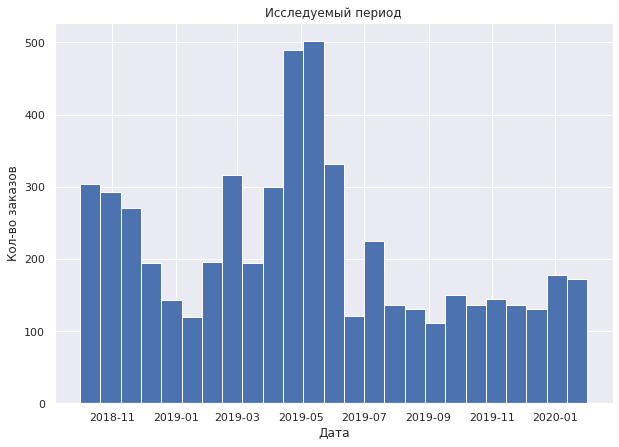

In [ ]:
plt.figure(figsize=(10,7)) 
plt.title('Исследуемый период')
df['date'].hist(bins=25)
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.show()

Мы располагаем данными с 2018-10-01 по 2020-01-31. На графике отчетливо виден пик кол-ва заказов, пришедшийся на май-июнь 2019 года. В целом наблюдается постепенное снижение количества заказов

In [ ]:
num_products = len(df['product'].unique())
unique_users = len(df['customer_id'].unique())
print('Количество уникальных товаров:', num_products)
print('Количество уникальных пользователей:', unique_users)

Количество уникальных товаров: 2290
Количество уникальных пользователей: 2350


In [ ]:
print('Список товаров:', df['product'].unique())


product_counts = df['product'].value_counts()

print('Количество товаров по категориям:')
for product, count in product_counts.items():
    print(f'{product}: {count}')

Список товаров: ['комнатное растение в горшке алое вера, d12, h30'
 'комнатное растение в горшке кофе арабика, d12, h25'
 'радермахера d-12 см h-20 см' ...
 'сумка-тележка хозяйственная rolser bab010 rojo joy-1800 красная'
 'кружка с трубочкой attribute мяч 500 мл jar501'
 'искусственный цветок подснежник садовый пластиковый белый']
Количество товаров по категориям:
пеларгония розебудная red pandora укорененный черенок: 65
пеларгония розебудная prins nikolai укорененный черенок: 54
пеларгония зональная диам. 12 см сиреневый полумахровый: 53
сумка-тележка 2-х колесная gimi argo синяя: 47
пеларгония розебудная mary укорененный черенок: 40
пеларгония розебудная margaretha укорененный черенок: 31
пеларгония розебудная queen ingrid укорененный черенок: 31
пеларгония зональная махровая лососевая: 25
пеларгония зональная ринго вайт d-7 см h-10 см укорененный черенок: 25
пеларгония зональная диам. 12 см коралловая полумахровая: 24
пеларгония зональная диам. 12 см темнорозовая полумахровая: 22


In [ ]:
dictionary = {
    
    'товары для дома': ['подставка','стеллаж','комод','карниз','этажерка','пуф','обувниц','светиль','фото',
               'для обув','комод','защитный','обувница','обуви','светильник','бак','вакуумный','весы',
                'петля','вешалка','вешалки','вкладыши','корзина','короб','коробка','кофр', 
                'крючок','обувная','лоток','мусора','монетчатый','мусорный','набор вешалок','котовник','петля', 
                'сумка','тележ','плечики','полки','решетка','складная','стеллаж','сумка','тележка',
                'хозяйственная','урна','этажерка','ящик'],
    
    'кухня':['банка','бидон','блюдо','блюдце','ваза','вилка','разделочная','емкость','жестяная','измельчитель',
             'картофелемялка','кастрюля','кипятильник','кисточка','хлебница','интерьерный','кружка',
             'крышка', 'кувшин', 'кухонное','кухонные','столовая','чайная','холодца','мантоварка',
             'пароварка','масленка','мерный','стакан','миксер','мини-сковорода','мирт','миска','модульная', 
             'набор бокалов','набор для пикника','набор ножей','webber','набор стаканов','набор столовых приборов',
             'набор фужеров','фужер','стакан','салатник','нож','ножеточка','овощеварка','овощечистка',
             'подушка','покрывало','просеиватель','противень','разделочная','салатник','салфетка','сковорода',
             'скребок','соковарка','соковыжималка','стакан','стеклянная','тepмокружка','тарелка', 'терка',
             'термокружка','толкушка','фал','форма','хлебница','ложка','чайная','чайник','электроштопор','сито', 
             'подставка для яйца'],
    
    'ванная':['ванна','вантуз','ведро','держатель','дозатор','ерш','запасная','ванной','коврик','ванной', 
              'ковш','мыльница','ванн','подголовник','пробка','унитаза',
             'зубная','мыло','жидкое','мыло-скраб','увлажняющая','маска','фен','сушилка для белья'],
    
    'текстиль':['скатерть','двуспальное','постельное','белье', 'ковер', 'кольца', 'штор', 'полотенце','штора', 
                'ковер', 'махровое','халат','набор ковров', 'наволочка', 'наматрасник', 'одеяло', 'плед', 
                'подкладка', 'чехол','полотенце','простыня','скатерть','халат','чехол','штора',
                'простынь вафельная 200х180 см wellness', 'наматрацник natures бархатный', 'покрывало жаккард шенилл birhome',
                'покрывало жаккард шенилл'],
    
    'cад':['а патио','адиантум','азалия','аквилегия','алиссум','амариллис','альбука','андесса','антижир',
           'арбуз','артемизия','аспарагус','астра','ахарница','бадан','базилик','бак','баклажан',
           'бакопа','бальза','барвинок','бархатцы','бегония','буддлея', 'бузульник', 'валериана', 'вербена',
           'виола', 'газания', 'гвоздика','гардения', 'георгина', 'герань', 'гербера', 'гимнокалициум', 'гиностемма',
           'гипсофила','годеция','горох','гортензия', 'декабрист', 'декоративная','дендробиум', 
           'джункус', 'томата', 'диффенбахия','дыня', 'ель', 'чабер', 'замиокулькас', 'зверобой', 'земляника', 
           'змееголовник', 'импатиенс','иссоп','сантолина', 'кабачок', 'каланхое', 'календула', 'калибрахоа', 
           'калла', 'калоцефалус', 'камнеломка','кампанула', 'капуста', 'кипарисовик', 'клен', 'клубника',
           'колокольчик', 'растение', 'кориандр','космея', 'крассула', 'крокусы','лаванда', 'мята', 'лантана', 
           'лапчатка','лен', 'литопс', 'порей', 'львиный', 'зев','любисток','мединилла','мелисса','многолетнее', 'молодило',
           'петрушка','морковь', 'мята', 'настурция','незабудка','нолина', 'огурец', 'растение','однолетнее', 'осина',
           'орехоколка','патиссон','пахира', 'пеларгония', 'пеларгония', 'петрушка', 'петуни', 'подвесное',
           'цветов','портулак', 'примула', 'пуансеттия','радермахера', 'роза','розмарин','рудбекия','скиммия', 
           'спатифиллум','суккулент','сциндапсус', 'тимьян','томат', 'томата', 'тортница', 'тюльпан', 'рассада', 
           'ранункулус','тыква', 'фаленопсис','фиалка', 'фикус', 'фиттония', 'флокс', 'фуксия', 'хризантема', 
           'целозия', 'цикламен', 'шалфей','эвкалипт','эпипремнум', 'эхеверия', 'эшшольция', 'ясколка', 'шеффлера',
           'хризолидокарпус', 'циперус', 'юкка нитчатая', 'рассада зелени для кухни', 'нефролепис', 'овсянница сизая серый',
           'хлорофитум','рассада','гиацинт'],
    
    'уборка':['ароматизиро', 'белье', 'прищепки','веник','гипоаллергенный','гель','гладильная','набор vileda', 
              'набор прищепок','доска','губка','гладильная','защитная','соль','кондиционер','контейнер','стирки', 
              'насадка', 'насадка','швабры','мытья','швабре','сушилка','настенная','настурция','ведра', 
              'пена','перчатки','тряп','швабр','совок','гладил','глажен','прищеп','налет','антижир','пылесос','крем', 
              'стир', 'щетка','сушилк','веник','подрукавник','совком', 'для чистки','стирки','мыть', 'средство',
              'мойк', 'утюг', 'покрытие','гладильной', 'пылесос','гладильной','совок','щетка','средство', 
              'таз','тряпка','корзина','швабра','щетка','средство', 'таз', 'корыто', 'паста для полировки', 
              'вантуз', 'швабр','губка','веник','сменный','дозатор', 'насадка', 'сметка', 'скребок', 'окномойка',
              'совок','чистящий','чистки','антижир','ведр','ерш','тряпка','отбеливатель','для стирки','стиральный',
              'сушилка для белья', 'настенная сушилка для', 'чехол для гладильной доски', 'сушилка для белья',
              'ароматизированное средство дудаления', 'чехол для гладильной доски', 'сушилка для белья', 'attribute', 'gimi',
              'сушилка для белья потолочная лиана люкс', 'сушилка для белья потолочная лиана люкс', 'прищепки для белья',
              'сушилка для белья потолочная zalger lift basic', 'linomatic', 'сушилка уличная', 'leifheit', 
              'сушилка уличная leifheit 85210 linomatic v 400 40 м 175х237х237','скребок для окон с рукояткой'],

    
    'инструменты':['инструмент','сверел','сверло','напильник','стремянк','стяжк','шпингалет','сварка',
                   'миксер','крепеж','пружин','петл','линейк','гои','бензин','завертка','крепеж','лестница',
                   'линейка','лопатка','шнур','строительного','многофункциональный','набор прецизионных','полировки',
                   'пьезозажигалка', 'ручка','сверло','седум','сетка','сметка','стремянка','стяжка','термометр',
                   'уголок','фарфоровая','сварка','шило','шнур','шпагат','штангенциркуль', 'чехол eurogold reflector' ],
    
    'декор':['искусственная', 'искусственный', 'декоративная', 'котовник', 'муляж', 'новогоднее', 'подарочный',
            'фоторамка', 'комнатное растение в горшке', 'муляж баклажан' ],
}

In [ ]:
def category_product(product):
    for category, items_of_list in dictionary.items():
        for item in items_of_list:
            if item in product:
                return category
    return category

In [ ]:
df['category'] = df['product'].apply(category_product)
df.sample(10)

,date,customer_id,order_id,product,quantity,price,revenue,date_no_time,year,month,day,week,hour,category
6698,2019-10-27 13:00:00,f0fe3add-04d4-4488-8852-7e9e25b95fe9,73101,хлорофитум d-7 см h-10 см укорененный черенок,2,74.0,148.0,2019-10-27,2019,10,6,43,13,cад
1418,2018-12-28 23:00:00,f84d0b80-6d88-4cc6-8f33-8ee4b3c8a5e4,69674,чехол для гладильной доски универсальный с пор...,1,239.0,239.0,2018-12-28,2018,12,4,52,23,текстиль
4117,2019-05-29 13:00:00,4f424a7c-3563-4316-b21f-1a65601226b2,14827,рассада зелени для кухни тимьяна в кассете по ...,1,191.0,191.0,2019-05-29,2019,5,2,22,13,cад
4053,2019-05-27 13:00:00,bebc738a-dfd3-4763-841b-b529504ce8de,71524,тележка багажная delta тбр-20 синий грузоподъе...,1,734.0,734.0,2019-05-27,2019,5,0,22,13,товары для дома
3290,2019-04-29 13:00:00,603e92a4-fc7f-4203-9ca5-103da5b008ac,14705,"однолетнее растение циния в кассете 4 шт, россия",1,82.0,82.0,2019-04-29,2019,4,0,18,13,cад
7279,2020-01-08 16:00:00,aa7151ae-8da0-41ca-85b6-5c1b331d5bdc,107324,"укроп обильнолистный 3,0 г 4660010772562",1,10.0,10.0,2020-01-08,2020,1,2,2,16,декор
908,2018-11-21 15:00:00,bed3914d-7118-4f6a-87e8-e0d8bc4fa60f,14507,пеларгония зональная диам. 12 см сиреневый пол...,1,188.0,188.0,2018-11-21,2018,11,2,47,15,cад
1009,2018-11-28 12:00:00,a1034d4c-91e4-42f5-87d5-75c7313e06ef,69137,гладильная доска colombo avantgard 120х40 см,1,4049.0,4049.0,2018-11-28,2018,11,2,48,12,уборка
2647,2019-04-04 10:00:00,eeec96e6-88f0-4d11-a100-0b3971840412,14614,"бакопа ампельная мега-крупная синяя объем 0,5 л",1,82.0,82.0,2019-04-04,2019,4,3,14,10,товары для дома
7292,2020-01-10 12:00:00,c197641b-e4f3-4c6d-b418-70d4ce0640c9,111224,тарелка обеденная luminarc грин форест 26 см h...,1,101.0,101.0,2020-01-10,2020,1,4,2,12,кухня


In [ ]:
category = df.groupby('category').agg({'product':'count'}).reset_index()
category.columns = ['category', 'count']
category['ratio'] = ((category['count'] / len(df))*100).round(1).astype('str')+'%'
display(category.sort_values(by='count', ascending = False))

,category,count,ratio
0,cад,2705,49.9%
6,товары для дома,734,13.5%
1,ванная,631,11.6%
4,кухня,406,7.5%
7,уборка,345,6.4%
2,декор,329,6.1%
5,текстиль,189,3.5%
3,инструменты,84,1.5%


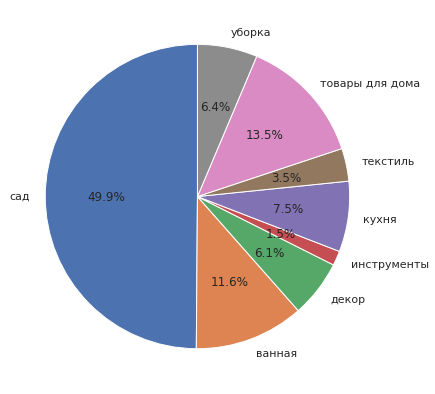

In [ ]:
plt.pie(x=category['count'], labels=category['category'], autopct='%1.1f%%', startangle=90)
plt.show()

2726 единиц(49,7%) составляют товары категории сад, далее идут 740 единиц(13,5%) товары для дома, 645 единиц (11,8%) ванная

**Топ-5 самых прибыльных товаров**

                                                    revenue
product                                                    
сумка-тележка 2-х колесная gimi argo синяя          50405.0
сушилка meliconi stendy junior                      27970.0
сумка-тележка 2-х колесная складная gimi flexi ...  19788.0
сумка-тележка 2-х колесная gimi galaxy черная       19568.0
сумка-тележка 3-х колесная gimi tris floral синяя   18893.0


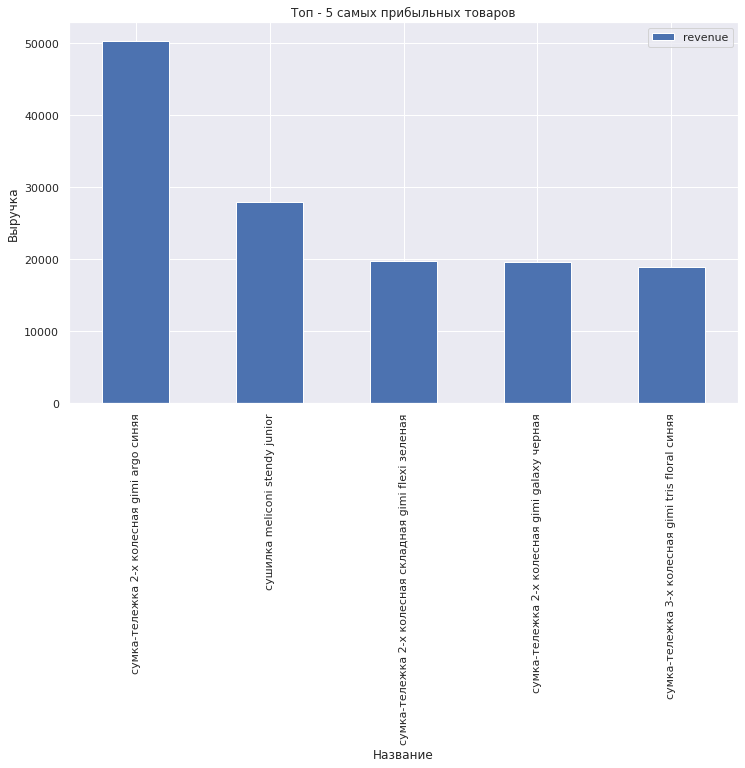

In [ ]:
top_5_by_revenue = pd.pivot_table(df, values='revenue', index='product', aggfunc='sum')
top_products = top_5_by_revenue.sort_values(by='revenue', ascending=False)[:5]
print(top_products)
top_products.plot(kind='bar')
plt.title('Топ - 5 самых прибыльных товаров')
plt.xlabel('Название')
plt.ylabel('Выручка')
plt.show()

прибыльнее всего сумки - тележки из категории товаров для дома

**топ - 5 самых продаваемых товаров**

                                                    quantity
product                                                     
цветок искусственный гвоздика пластиковая одино...        97
пеларгония розебудная red pandora укорененный ч...        80
однолетнее растение петуния махровая в кассете ...        76
ерш унитазный с деревянной ручкой , ваир 1712012          73
пеларгония зональная диам. 12 см сиреневый полу...        64


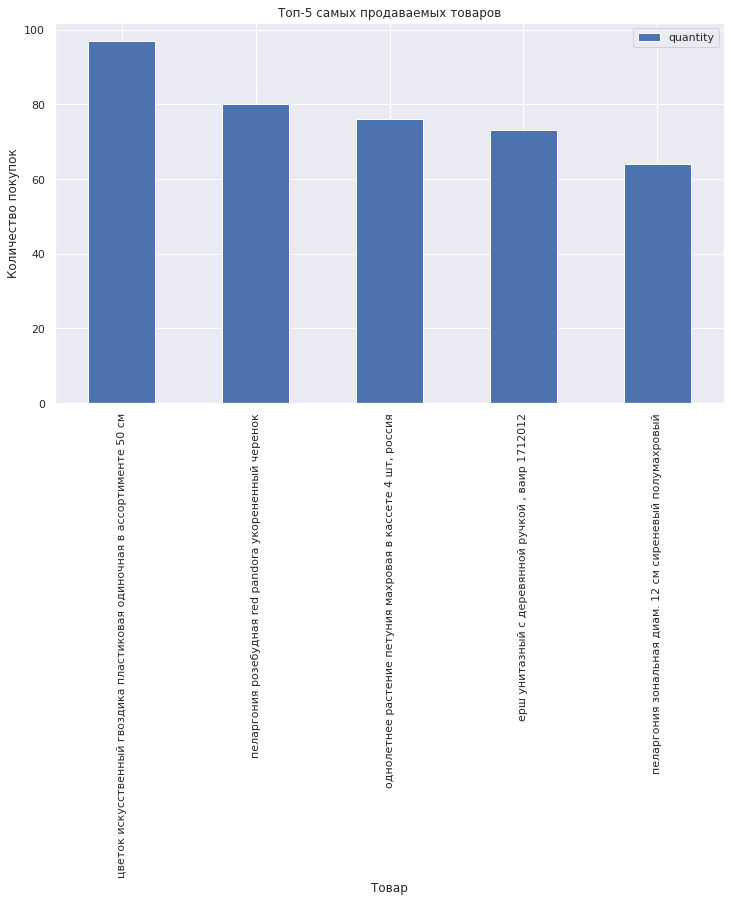

In [ ]:
top_5_by_quantity = pd.pivot_table(df, values='quantity', index='product', aggfunc='sum')
top_products = top_5_by_quantity.sort_values(by='quantity', ascending=False)[:5]
print(top_products)
top_products.plot(kind='bar')
plt.title('Топ-5 самых продаваемых товаров')
plt.xlabel('Товар')
plt.ylabel('Количество покупок')
plt.show()

чаще всего покупали товары из категории сад

**Определение самой прибыльной категории товаров**

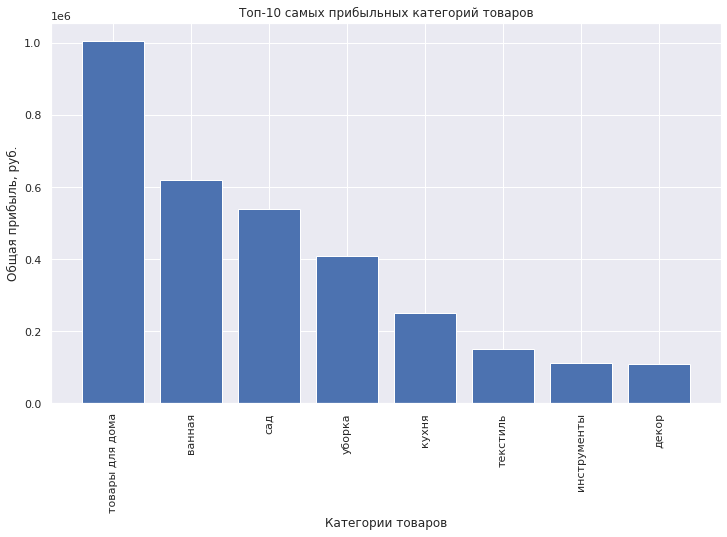

In [ ]:
category_revenue = df.pivot_table(index='category', values='revenue', aggfunc='sum')
category_revenue = category_revenue.sort_values(by='revenue', ascending=False)
plt.bar(category_revenue.index, category_revenue['revenue'])
plt.xticks(rotation=90)
plt.xlabel('Категории товаров')
plt.ylabel('Общая прибыль, руб.')
plt.title('Топ-10 самых прибыльных категорий товаров')
plt.show()

Наибольшую вырочку приносят категория товары для дома, ванная. Меньше всего инструменты и декор

**Определение самых продаваемых категорий товара**

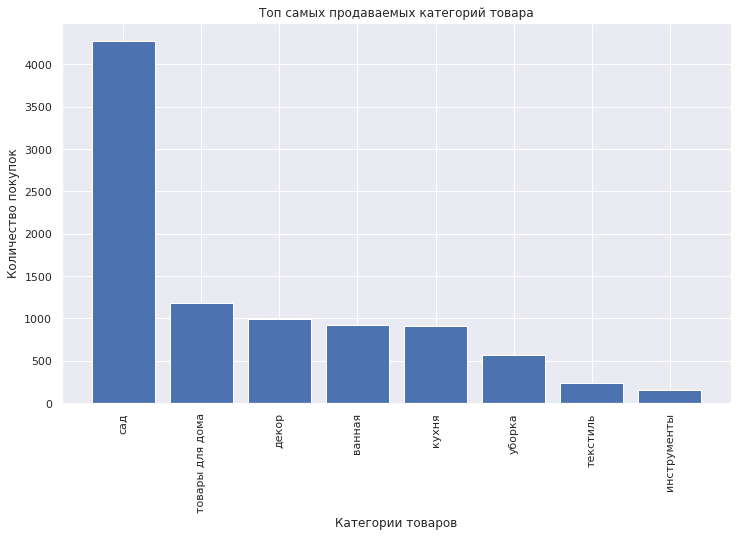

In [ ]:
category_quantity = df.pivot_table(index='category', values='quantity', aggfunc='sum')
category_quantity = category_quantity.sort_values(by='quantity', ascending=False)
plt.bar(category_quantity.index, category_quantity['quantity'])
plt.xticks(rotation=90)
plt.xlabel('Категории товаров')
plt.ylabel('Количество покупок')
plt.title('Топ самых продаваемых категорий товара')
plt.show()

Чаще всего покупают товары категории сад, меньше всего категории инструменты

**сколько товаров в среднем покупает пользователь**

In [ ]:
print('Среднее количество товаров в заказе:', 
      round(df.groupby(
    'order_id')['product'].nunique().mean(),2))

Среднее количество товаров в заказе: 1.6


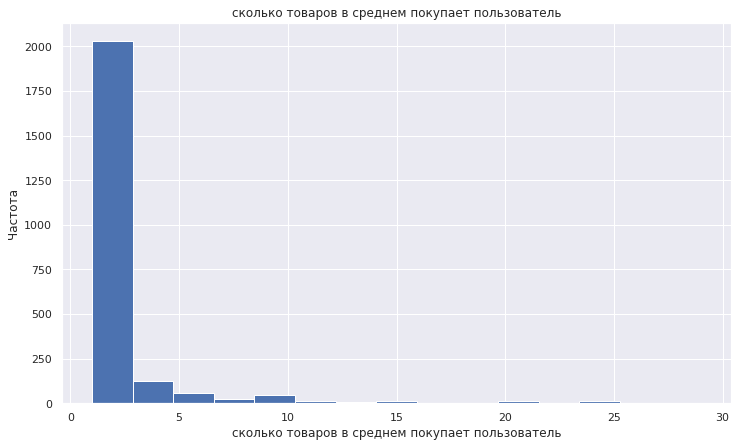

In [ ]:
avg_quantity = df.groupby('customer_id')['quantity'].mean()
plt.hist(avg_quantity, bins=15)
plt.xlabel('сколько товаров в среднем покупает пользователь')
plt.ylabel('Частота')
plt.title('сколько товаров в среднем покупает пользователь')
plt.show()

чаще всего пользователи покупают 1-2 товара

**Определение среднего чека клиента по меясцам**

In [ ]:
avg_check = df['revenue'].mean()
print('Средний чек :',avg_check)

Средний чек : 588.3860255701027


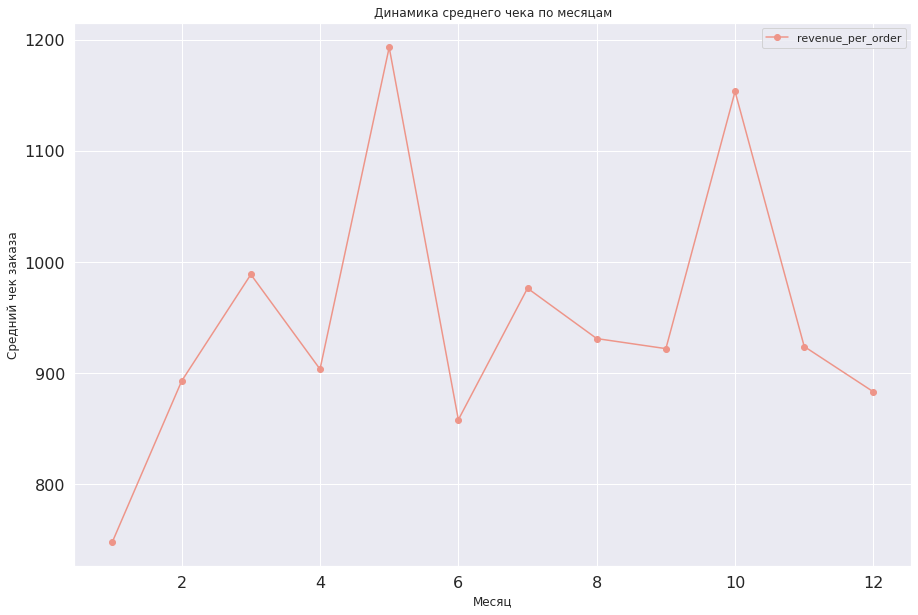

In [ ]:
avg_check = df.groupby(['month']) \
                                    .agg({'revenue':'sum','customer_id':'nunique', 'order_id':'nunique'}).reset_index()
avg_check.columns = ['month', 'revenue', 'customers', 'orders']
avg_check['revenue_per_order'] = avg_check['revenue'] / avg_check['orders']
avg_check = avg_check.pivot_table(index = ['month'],values = 'revenue_per_order')
avg_check.columns = ['revenue_per_order']
avg_check.sort_values(by='revenue_per_order',ascending=False)
avg_check.plot(marker='o', y=['revenue_per_order'], figsize=(15,10), grid=True, color='#ee9589', fontsize=16)
plt.title('Динамика среднего чека по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средний чек заказа')
plt.show()

Наблюдается стабильное падение среднего чека на протяжении всего наблюдения. В начале исследования средний чек находился в размере 1400 рублей,под конец исследования 600

**поиск средней выручки с одного клиента и ее динамика**

In [ ]:
revenue_sum = df['revenue'].sum()
print('Сумма выручки: {:.2f} д.e.'.format(revenue_sum))

Сумма выручки: 3190817.42 д.e.


In [ ]:
revenue_mean = df['revenue'].mean()
print('Cредняя выручка с покупателя: {:.2f} д.e.'.format(revenue_mean))

Cредняя выручка с покупателя: 588.39 д.e.


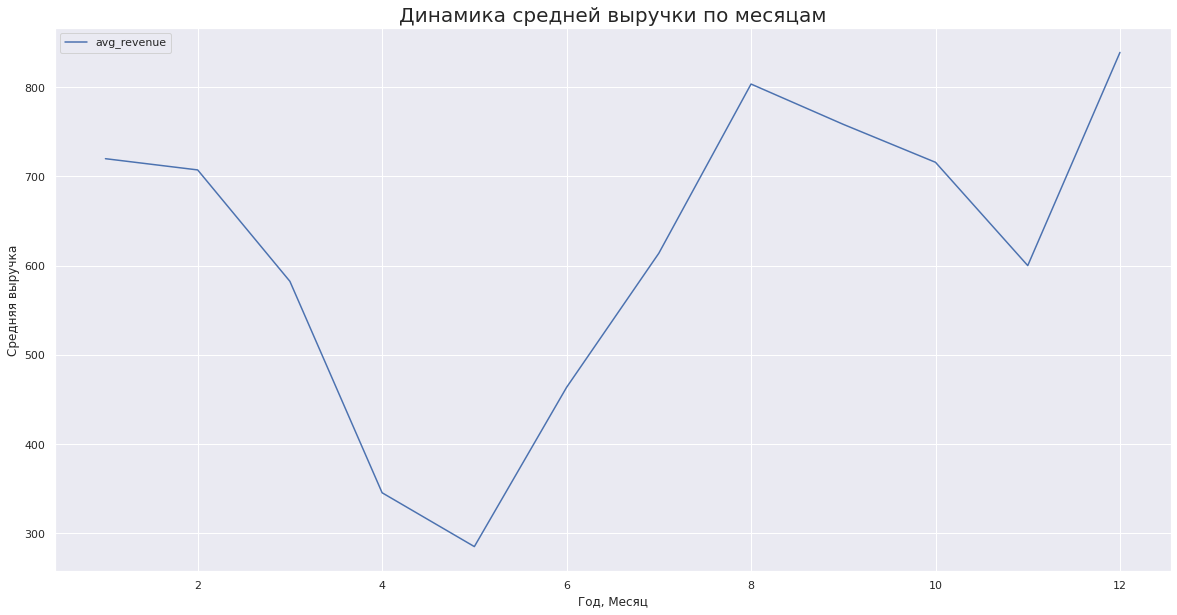

In [ ]:
avg_revenue_month = df.pivot_table(index = ['month'],values = 'revenue',aggfunc = 'mean')
avg_revenue_month.columns = ['avg_revenue']
avg_revenue_month.sort_values(by = 'avg_revenue',ascending = False)
avg_revenue_month.plot(y = ['avg_revenue'],figsize = (20,10),grid = True)
plt.title('Динамика средней выручки по месяцам', fontsize=20)
plt.xlabel('Год, Месяц')
plt.ylabel('Средняя выручка')
plt.show()

Средняя выручка в мае 2019 года находилась на самом низком уровне за все время исследования, потом наблюдается стабильный рост

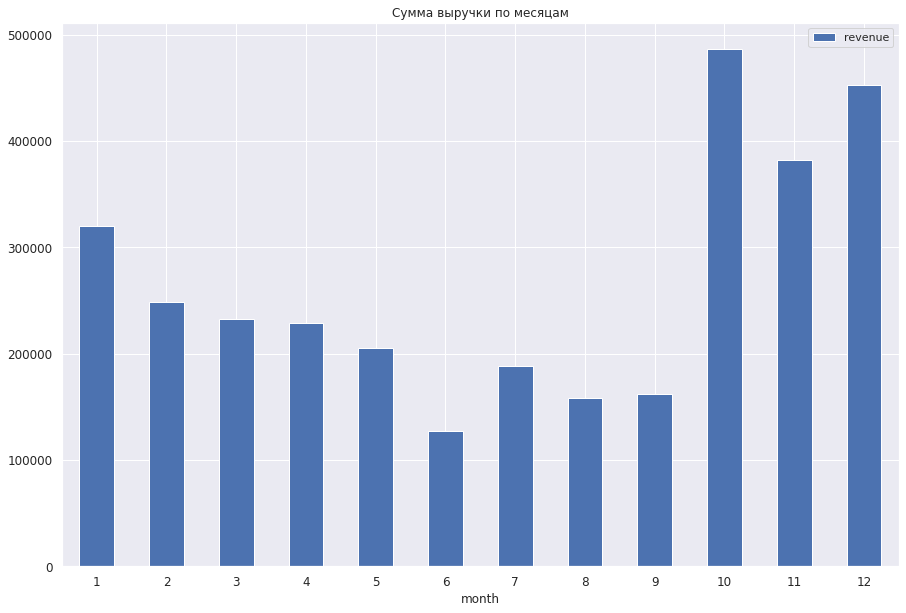

In [ ]:
df.pivot_table(index = 'month',values = 'revenue',aggfunc = 'sum',fill_value = 0)\
.plot(kind = 'bar',figsize = (15,10),grid = True,y = 'revenue',fontsize = 12)
plt.xticks(rotation = 0)
plt.title('Сумма выручки по месяцам')
plt.show()

На графике видно,что сумма выручки по месяцам в целом снижалась почти каждый месяц за все время исследования

**посмотрим на сезонность категорий**

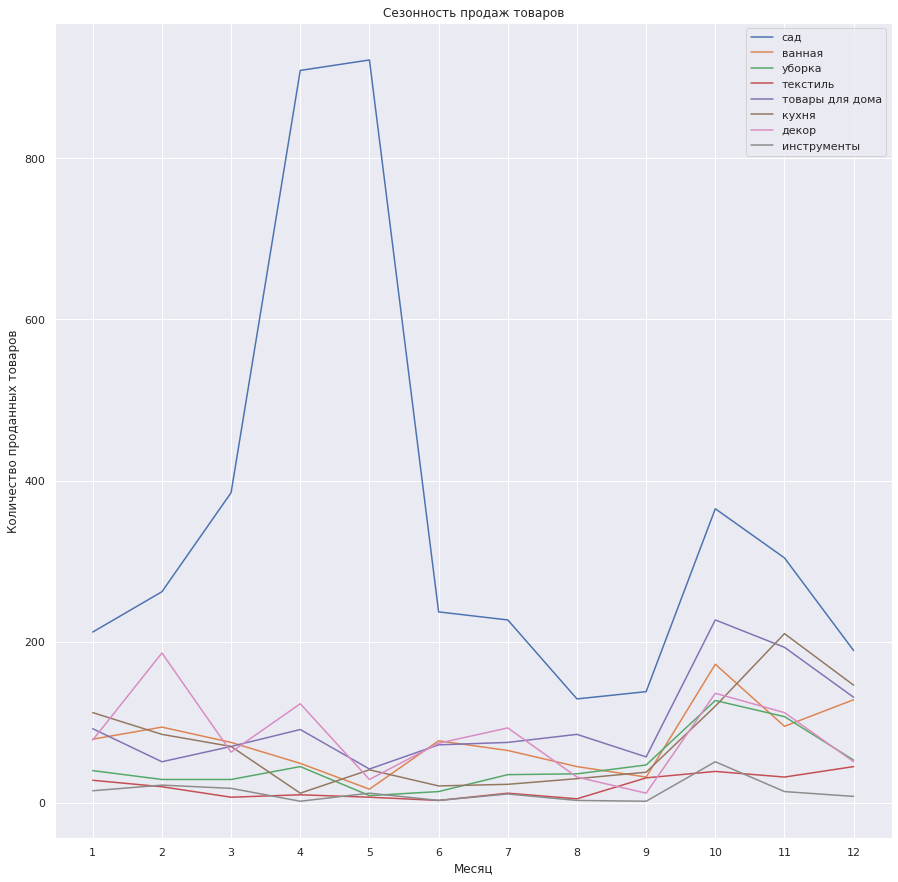

In [ ]:
seasonal_products = df.groupby(['month', 'category'])['quantity'].sum().reset_index()

seasonal_products['month'] = seasonal_products['month'].astype(str)

categories = df['category'].unique()

fig, ax = plt.subplots(figsize=(15, 15))

for category in categories:
    data = seasonal_products[seasonal_products['category'] == category]
    ax.plot(data['month'], data['quantity'], label=category)

ax.set_title('Сезонность продаж товаров')
ax.set_xlabel('Месяц')
ax.set_ylabel('Количество проданных товаров')
ax.legend()
plt.show()

сильно выражена сезонность у категории сад, в апреле-мае 2019 эту категорию заказывали чаще всего

**в какой день недели больше всего заказов**

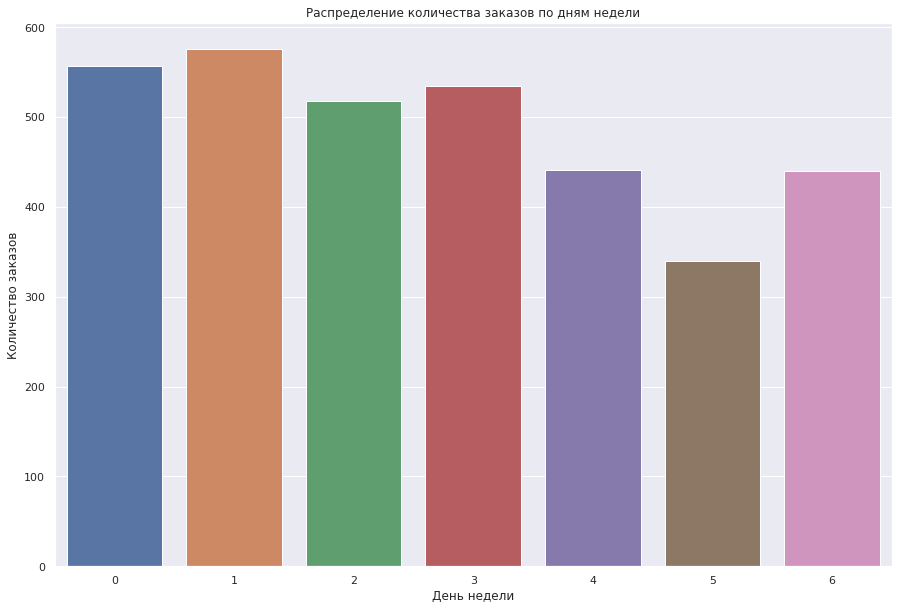

In [ ]:
day_index = df.groupby('day')['order_id'].nunique().index
day_values = df.groupby('day')['order_id'].nunique().values

plt.figure(figsize=(15,10))
ax = sns.barplot(x=day_index, y=day_values)
ax.set(title = 'Распределение количества заказов по дням недели', 
       xlabel='День недели', 
       ylabel='Количество заказов')
plt.show()

на графике видно, что чаще всего заказывают в начале недели, ближе к выходным заказывают меньше всего

**в какое время больше всего заказов**

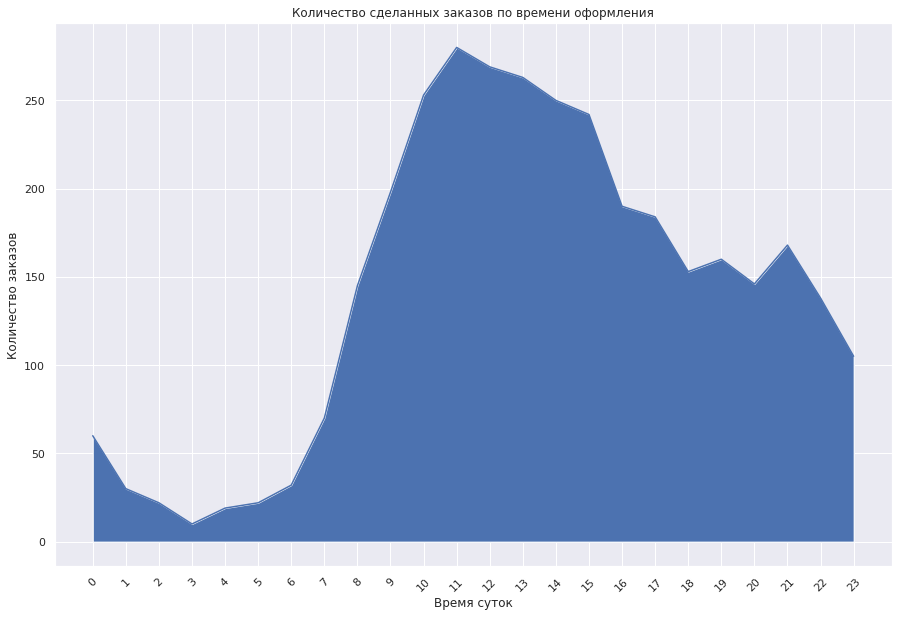

In [ ]:
plt.figure(figsize=(15,10))

hour_index = df.groupby('hour')['order_id'].nunique().index.astype(str)
hour_values = df.groupby('hour')['order_id'].nunique().values

ax = sns.lineplot(x=hour_index, y=hour_values)
ax.set_title('Количество сделанных заказов по времени оформления')
ax.set_xlabel('Время суток')
ax.set_ylabel('Количество заказов')

plt.fill_between(hour_index,hour_values )
plt.xticks(rotation=45)
plt.show()

чаще всего заказывают утром/днем с 8 до 15

**количества покупателей по месяцам**

In [ ]:
print('Среднее количество клиентов в месяц:', round(
    df.groupby('month')['customer_id'].nunique().mean()))

Среднее количество клиентов в месяц: 254


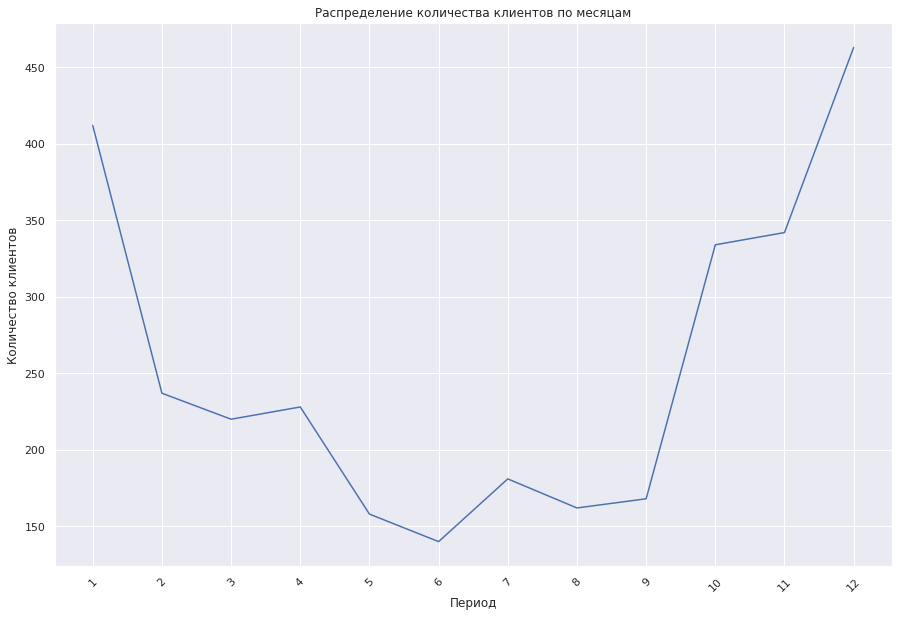

In [ ]:
plt.figure(figsize=(15,10))

count_of_month_values = df.groupby('month')['customer_id'].nunique().index.astype(str)
count_of_match_index = df.groupby('month')['customer_id'].nunique().values

ax = sns.lineplot(x=count_of_month_values, y=count_of_match_index)
plt.title('Распределение количества клиентов по месяцам')
plt.xlabel('Период')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=45)
plt.show()

на графике наблюдаем резкий спад количества клиентов в январе 2019, что обьясняется длинными праздниками, после октябпя 2019 заметен резкий рост количества клиентов

In [ ]:
df.describe()

,order_id,quantity,price,revenue,year,month,day,week,hour
count,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000,5423.000000
mean,55604.508021,1.707726,493.361808,588.386026,2018.829799,6.666052,2.722663,27.119675,13.970680
std,32682.625997,2.531533,821.424446,901.571310,0.489639,3.605250,1.973958,15.644587,4.943173
min,12624.000000,1.000000,9.000000,9.000000,2018.000000,1.000000,0.000000,1.000000,0.000000
25%,14800.000000,1.000000,90.000000,120.000000,2019.000000,4.000000,1.000000,15.000000,11.000000
50%,69156.000000,1.000000,150.000000,188.000000,2019.000000,6.000000,3.000000,23.000000,14.000000
75%,71937.500000,1.000000,520.500000,689.000000,2019.000000,10.000000,4.000000,43.000000,17.000000
max,112789.000000,29.000000,6134.000000,6148.000000,2020.000000,12.000000,6.000000,52.000000,23.000000


## Сегментация k-means

<div class="alert alert-info"> <b>Комментарий студента v.2:</b>Была проблема, что при кластеризации, получался кластер состоящий только из 1 покупателя. Причина оказалась в выбросах

In [ ]:
clusters_data = df.pivot_table(index = 'customer_id', aggfunc = {'order_id': 'nunique', 'quantity': 'sum','price':'mean', 
                        'revenue':'sum'})
clusters_data.columns = ['orders_count', 'quantity','price','revenue']
clusters_data.describe()

,orders_count,quantity,price,revenue
count,2350.000000,2350.000000,2350.000000,2350.000000
mean,1.445532,661.499997,3.940851,1357.794645
std,2.675952,828.106915,8.482892,3510.600303
min,1.000000,14.000000,1.000000,15.000000
25%,1.000000,135.000000,1.000000,374.250000
50%,1.000000,342.500000,2.000000,806.500000
75%,2.000000,899.000000,3.000000,1661.500000
max,124.000000,6134.000000,260.000000,150812.000000


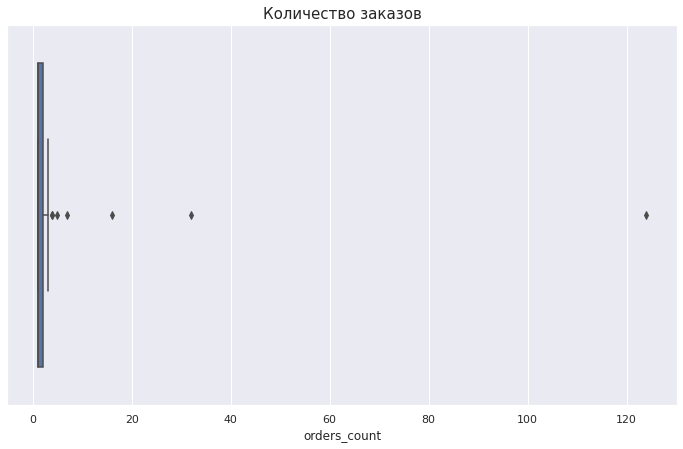

In [ ]:
sns.boxplot(x='orders_count', data=clusters_data)
plt.title('Количество заказов', fontsize=15)
plt.show()

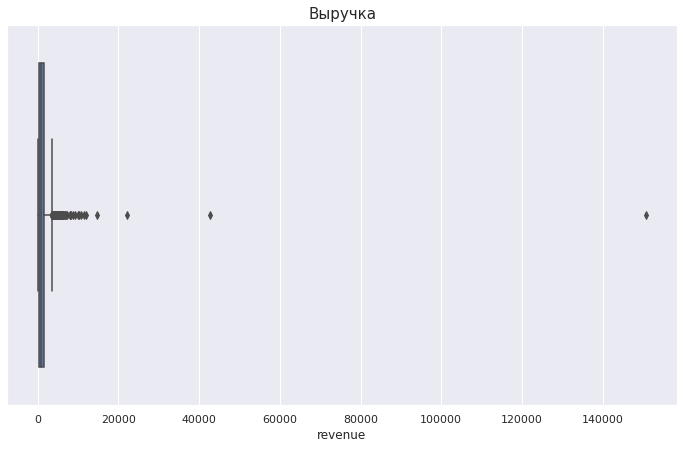

In [ ]:
sns.boxplot(x='revenue', data=clusters_data)
plt.title('Выручка', fontsize=15)
plt.show()

In [ ]:
upper_r = clusters_data['revenue'].quantile(.99)

In [ ]:
upper_or = clusters_data['orders_count'].quantile(.99)

In [ ]:
clusters_data = clusters_data[(clusters_data['revenue'] < 40000)]
clusters_data = clusters_data[(clusters_data['orders_count'] < 30)]

In [ ]:
clusters_data.describe()

,orders_count,quantity,price,revenue
count,2348.000000,2348.000000,2348.000000,2348.000000
mean,1.380324,661.352989,3.772998,1276.485271
std,0.604405,828.438505,5.994601,1441.780764
min,1.000000,14.000000,1.000000,15.000000
25%,1.000000,134.875000,1.000000,374.000000
50%,1.000000,340.875000,2.000000,803.500000
75%,2.000000,899.000000,3.000000,1657.750000
max,16.000000,6134.000000,68.000000,22056.000000


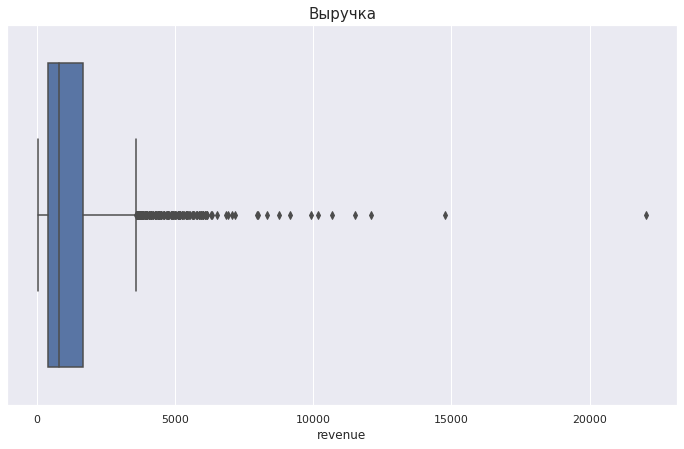

In [ ]:
sns.boxplot(x='revenue', data=clusters_data)
plt.title('Выручка', fontsize=15)
plt.show()

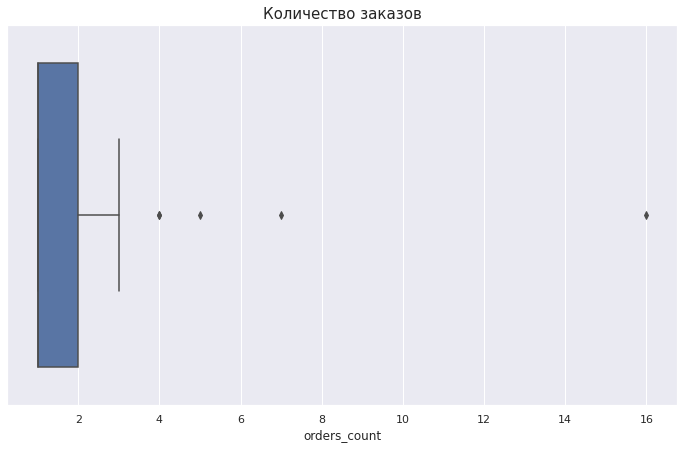

In [ ]:
sns.boxplot(x='orders_count', data=clusters_data)
plt.title('Количество заказов', fontsize=15)
plt.show()

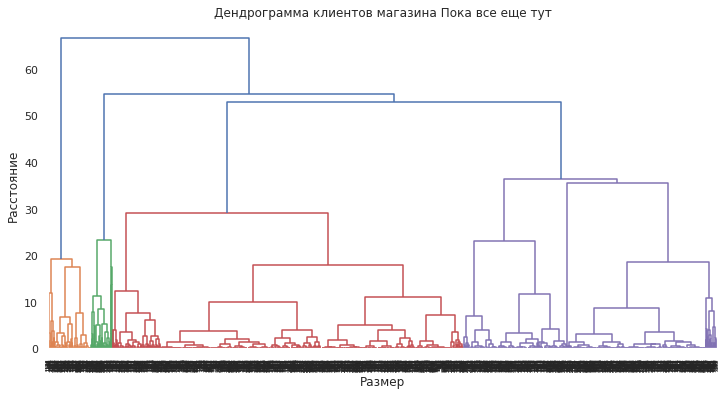

In [ ]:
scaler = StandardScaler()

k_means = scaler.fit_transform(clusters_data)

k_linked = linkage(k_means, method = 'ward')

plt.figure(figsize=(12, 6)) 
dendrogram(k_linked, orientation='top')
plt.title("Дендрограмма клиентов магазина Пока все еще тут")
plt.xlabel("Размер")
plt.ylabel("Расстояние")
plt.show()

In [ ]:
k_means = KMeans(n_clusters=4,random_state = 0)
labels = k_means.fit_predict(clusters_data)
clusters_data['clusters'] = labels
clusters_data.sample(10)

,orders_count,quantity,price,revenue,clusters
customer_id,,,,,
03865a43-8c19-4d4e-ab51-7ec516614a83,1,135.000000,2,270.000000,2
d35dc984-b84f-4dbf-9f1a-a04e14e528c9,1,2099.000000,2,4198.000000,1
66c57efd-4dd1-49c9-b921-987ab6e161fa,2,337.000000,2,674.000000,2
44fbc498-ec5a-4a18-b2ca-2764a36407f8,1,262.000000,6,1572.000000,0
526d57c3-7860-44ce-a22a-acb5eabd9d65,2,406.666667,2,813.333333,2
6d20d222-e094-4b5a-b24a-5764fe004e1f,2,1169.000000,2,2338.000000,0
4d605e0d-21ad-4e8f-aa3e-8233a6adf618,1,1949.000000,1,1949.000000,0
c246ad01-a0b5-4cca-8cdb-c5a05d637e0d,2,397.000000,2,794.000000,2
d7d0a3e8-70fd-4360-9c25-fc212108cac6,2,621.500000,3,2292.000000,0


In [ ]:
clusters_data['avg_check'] = clusters_data['revenue'] / clusters_data['orders_count']
display(clusters_data.groupby(['clusters']).mean().T)

clusters,0,1,2,3
orders_count,1.451078,1.511111,1.319629,3.000000
quantity,966.867327,2379.090964,265.071724,2901.016121
price,4.633499,4.217778,3.292440,12.583333
revenue,1882.661001,4133.734074,529.542882,11108.500000
avg_check,1435.356383,3051.430519,431.499779,6829.491319


In [ ]:
clusters_data.head()

,orders_count,quantity,price,revenue,clusters,avg_check
customer_id,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,1,138.75,4,555.0,2,555.0
001cee7f-0b29-4716-b202-0042213ab038,1,442.00,1,442.0,2,442.0
00299f34-5385-4d13-9aea-c80b81658e1b,1,457.00,2,914.0,2,914.0
002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.00,1,1649.0,0,1649.0
003bbd39-0000-41ff-b7f9-2ddaec152037,1,1162.00,2,2324.0,0,2324.0


In [ ]:
data_k = clusters_data.reset_index(drop=False)
data_k.head(5)

,customer_id,orders_count,quantity,price,revenue,clusters,avg_check
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,138.75,4,555.0,2,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,1,442.00,1,442.0,2,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,457.00,2,914.0,2,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.00,1,1649.0,0,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,1162.00,2,2324.0,0,2324.0


In [ ]:
df.head()

,date,customer_id,order_id,product,quantity,price,revenue,date_no_time,year,month,day,week,hour,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0,2018-10-01,2018,10,0,40,0,cад
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,194.0,2018-10-01,2018,10,0,40,0,cад
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0,2018-10-01,2018,10,0,40,0,cад
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,179.0,2018-10-01,2018,10,0,40,0,cад
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,112.0,2018-10-01,2018,10,0,40,0,cад


In [ ]:
df = df.merge(data_k[['customer_id','clusters']], on='customer_id', how='left')
df.rename(columns = {'clusters_y': 'clusters'},inplace = True)
df = df.dropna (subset=['clusters'])
df['clusters'] = df['clusters'].astype('int')
df.head(5)

,date,customer_id,order_id,product,quantity,price,revenue,date_no_time,year,month,day,week,hour,category,clusters
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0,2018-10-01,2018,10,0,40,0,cад,2
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,194.0,2018-10-01,2018,10,0,40,0,cад,2
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0,2018-10-01,2018,10,0,40,0,cад,2
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,179.0,2018-10-01,2018,10,0,40,0,cад,2
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,112.0,2018-10-01,2018,10,0,40,0,cад,2


После проведения сегментации мы определили 4 сегмента покупателей. 

- 0 кластер -  среднее количество заказов 1, количество товаров в заказе 2369, выручка 4220, средний чек 3268. Предпочитают сад, товары для дома и уборку. Активнее всего берут категорию сад весной, также проявляют интерес к кухне и товарам для дома с лета по осень. 

- 1 клакстер - среднее количество заказов 1, количество товаров в заказе 958, выручка 1867, средний чек 1397. Лидирует у этой категории с большим отрывом сад, потом идет товары для дома, ванная, кухня. Покупатели этого кластера с весной по зиму закупаются товарами из категории сад

- 2 кластер - среднее количество заказов 3, количество товаров в заказе 2599, выручка 12116, средний чек 7758. Оптовые покупатели. Их интересуют товары для дома и в меньшей степени сад. Ярко выражена сезонность - летом по осень покупают товары для дома

- 3 кластер - среднее количество заказов 1, количество товаров в заказе 264, выручка 512, средний чек 403. Розничные покупатели. На первом месте по популярности сад, декор, ванная, кухня, товары для дома. Ярко выражена сезонность у категории сад


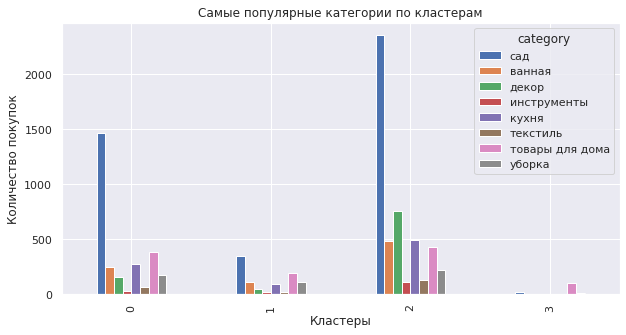

In [ ]:
df_grouped = df.groupby(['clusters', 'category'])['quantity'].sum().reset_index()
df_pivot = df_grouped.pivot(index='clusters', columns='category', values='quantity')
df_pivot.plot(kind='bar',  figsize=(10, 5))
plt.title('Самые популярные категории по кластерам')
plt.xlabel('Кластеры')
plt.ylabel('Количество покупок')
plt.show()

In [ ]:
def season(month):
    if  3 <= month <= 5:
        return 'весна'
    elif 6 <= month <= 8:
        return 'лето'
    elif 9 <= month <= 11:
        return 'осень'
    else:
        return 'зима'

In [ ]:
df['season'] = df['month'].apply(season)
df.head(5)

,date,customer_id,order_id,product,quantity,price,revenue,date_no_time,year,month,day,week,hour,category,clusters,season
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0,2018-10-01,2018,10,0,40,0,cад,2,осень
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,194.0,2018-10-01,2018,10,0,40,0,cад,2,осень
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0,2018-10-01,2018,10,0,40,0,cад,2,осень
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,179.0,2018-10-01,2018,10,0,40,0,cад,2,осень
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,112.0,2018-10-01,2018,10,0,40,0,cад,2,осень


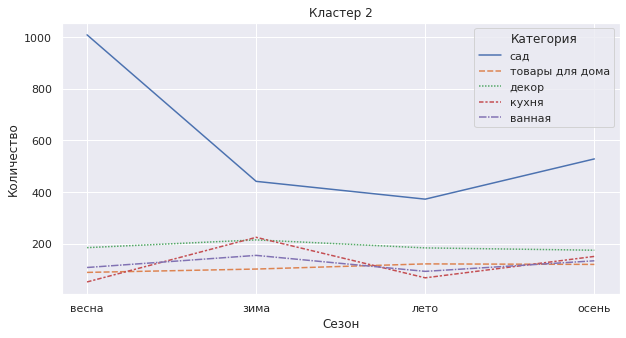

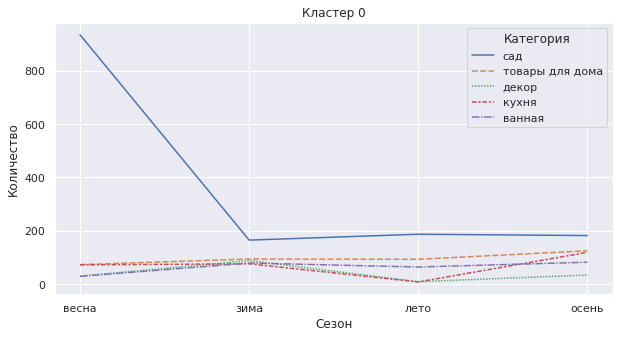

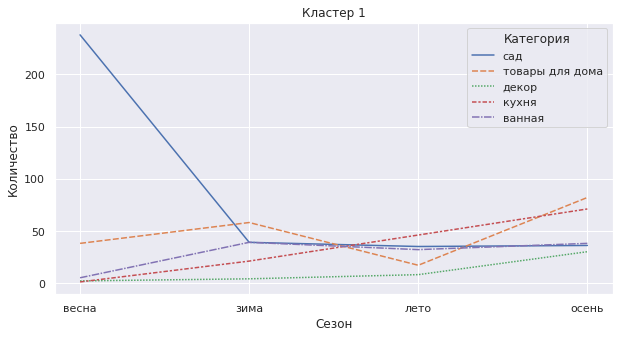

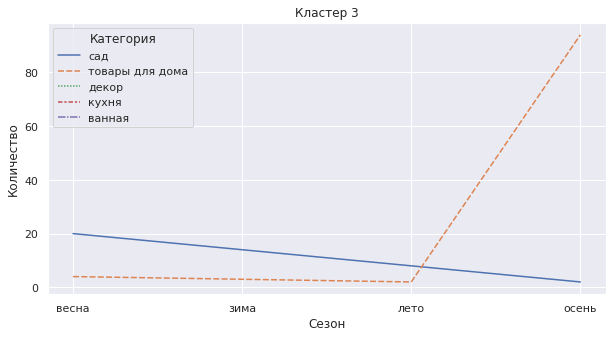

In [ ]:
pivot = df.pivot_table(index=['clusters', 'season'], columns='category', values='quantity', aggfunc='sum')
top_categories = pivot.sum().sort_values(ascending=False).head(5).index.tolist()
for cluster in df['clusters'].unique():
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=pivot.loc[cluster].loc[:, top_categories])
    plt.title(f'Кластер {cluster}')
    plt.xlabel('Сезон')
    plt.ylabel('Количество')
    plt.legend(title='Категория')
    plt.show()


**Выводы**
- 0 клакстер - среднее количество заказов 1, количество товаров в заказе 966, выручка 1882, средний чек 1435. Лидирует у этой категории с большим отрывом сад, потом идет товары для дома, ванная, кухня. Покупатели этого кластера с весной по зиму закупаются товарами из категории сад

- 1 кластер -  среднее количество заказов 1, количество товаров в заказе 2379, выручка 4133, средний чек 3051. Предпочитают сад, товары для дома и уборку. Активнее всего берут категорию сад весной, также проявляют интерес к кухне и товарам для дома с лета по осень.

- 2 кластер - среднее количество заказов 1, количество товаров в заказе 265, выручка 529, средний чек 431. Розничные покупатели. На первом месте по популярности сад, декор, ванная, кухня, товары для дома. Ярко выражена сезонность у категории сад

- 3 кластер - среднее количество заказов 3, количество товаров в заказе 2901, выручка 11108, средний чек 6829. Оптовые покупатели. Их интересуют товары для дома и в меньшей степени сад. Ярко выражена сезонность - летом по осень покупают товары для дома

## Проверка статистических гипотез

In [ ]:
display(clusters_data.groupby(['clusters']).mean().T)

clusters,0,1,2,3
orders_count,1.451078,1.511111,1.319629,3.000000
quantity,966.867327,2379.090964,265.071724,2901.016121
price,4.633499,4.217778,3.292440,12.583333
revenue,1882.661001,4133.734074,529.542882,11108.500000
avg_check,1435.356383,3051.430519,431.499779,6829.491319


- H0: Нет различий в среднем чеке между сегментами покупателей
- H1: Есть различия в среднем чеке между сегментами покупателей

In [ ]:
cluster0 = clusters_data[clusters_data['clusters']==0]['avg_check']
cluster1 = clusters_data[clusters_data['clusters']==1]['avg_check']
cluster2 = clusters_data[clusters_data['clusters']==2]['avg_check']
cluster3 = clusters_data[clusters_data['clusters']==3]['avg_check']

Проверим на нормальность распределения методом Шапиро - Уилка

In [ ]:
stat, p = shapiro(cluster0)
print('Статистика теста:', stat)
print('p-value:', p)

if p > 0.05:
    print('Распределение похоже на нормальное')
else:
    print('Распределение не похоже на нормальное')

Статистика теста: 0.9035239219665527
p-value: 4.585442121475324e-19
Распределение не похоже на нормальное


In [ ]:
stat, p = shapiro(cluster1)
print('Статистика теста:', stat)
print('p-value:', p)

if p > 0.05:
    print('Распределение похоже на нормальное')
else:
    print('Распределение не похоже на нормальное')

Статистика теста: 0.9307040572166443
p-value: 8.293997488806326e-09
Распределение не похоже на нормальное


In [ ]:
stat, p = shapiro(cluster2)
print('Статистика теста:', stat)
print('p-value:', p)

if p > 0.05:
    print('Распределение похоже на нормальное')
else:
    print('Распределение не похоже на нормальное')

Статистика теста: 0.9220593571662903
p-value: 3.091397398362433e-27
Распределение не похоже на нормальное


In [ ]:
stat, p = shapiro(cluster3)
print('Статистика теста:', stat)
print('p-value:', p)

if p > 0.05:
    print('Распределение похоже на нормальное')
else:
    print('Распределение не похоже на нормальное')

Статистика теста: 0.7557739019393921
p-value: 0.003072317922487855
Распределение не похоже на нормальное


Тесты показали что распределение не является нормальным, тогда воспользуемся критерием Манна-Уитни

In [ ]:
alpha = 0.05 / 6
results = stats.mannwhitneyu(cluster0, cluster1) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.649448418257932e-74
Отвергаем нулевую гипотезу


In [ ]:
alpha = 0.05 / 6
results = stats.mannwhitneyu(cluster0, cluster2) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.0618272654247e-238
Отвергаем нулевую гипотезу


In [ ]:
alpha = 0.05 / 6
results = stats.mannwhitneyu(cluster0, cluster3) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.8037956802341326e-07
Отвергаем нулевую гипотезу


In [ ]:
alpha = 0.05 / 6
results = stats.mannwhitneyu(cluster1, cluster2) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.6023989522310563e-129
Отвергаем нулевую гипотезу


In [ ]:
alpha = 0.05 / 6
results = stats.mannwhitneyu(cluster1, cluster3) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0002738415721322449
Отвергаем нулевую гипотезу


In [ ]:
alpha = 0.05 / 6
results = stats.mannwhitneyu(cluster2, cluster3) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.735335331143952e-09
Отвергаем нулевую гипотезу


p-value значительно меньше 0.05. Значит есть статистически значимое различие в среднем объеме продаж между сегментами покупателей

**Гипотеза 2**

- H0: Нет различий в среднем объеме продаж между сегментами покупателей
- H1: Есть различия в среднем объеме продаж между сегментами покупателей

In [ ]:
sales_volume_cluster0 = clusters_data[clusters_data['clusters']==0]['quantity']
sales_volume_cluster1 = clusters_data[clusters_data['clusters']==1]['quantity']
sales_volume_cluster2 = clusters_data[clusters_data['clusters']==2]['quantity']
sales_volume_cluster3 = clusters_data[clusters_data['clusters']==3]['quantity']

In [ ]:
stat, p = shapiro(sales_volume_cluster0)
print('Статистика теста:', stat)
print('p-value:', p)

if p > 0.05:
    print('Распределение похоже на нормальное')
else:
    print('Распределение не похоже на нормальное')

Статистика теста: 0.9716380834579468
p-value: 2.085321249012395e-09
Распределение не похоже на нормальное


In [ ]:
stat, p = shapiro(sales_volume_cluster1)
print('Статистика теста:', stat)
print('p-value:', p)

if p > 0.05:
    print('Распределение похоже на нормальное')
else:
    print('Распределение не похоже на нормальное')

Статистика теста: 0.9581862092018127
p-value: 3.819118319370318e-06
Распределение не похоже на нормальное


In [ ]:
stat, p = shapiro(sales_volume_cluster2)
print('Статистика теста:', stat)
print('p-value:', p)

if p > 0.05:
    print('Распределение похоже на нормальное')
else:
    print('Распределение не похоже на нормальное')

Статистика теста: 0.8789637684822083
p-value: 1.02668073330162e-32
Распределение не похоже на нормальное


In [ ]:
stat, p = shapiro(sales_volume_cluster3)
print('Статистика теста:', stat)
print('p-value:', p)

if p > 0.05:
    print('Распределение похоже на нормальное')
else:
    print('Распределение не похоже на нормальное')

Статистика теста: 0.8576716184616089
p-value: 0.04571671783924103
Распределение не похоже на нормальное


Тесты показали что распределение не является нормальным, тогда воспользуемся критерием Манна-Уитни

In [ ]:
alpha = 0.05 / 6
results = stats.mannwhitneyu(sales_volume_cluster0, sales_volume_cluster1) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.071301636670237e-62
Отвергаем нулевую гипотезу


In [ ]:
alpha = 0.05 / 6
results = stats.mannwhitneyu(sales_volume_cluster0, sales_volume_cluster2) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.800204649709893e-161
Отвергаем нулевую гипотезу


In [ ]:
alpha = 0.05 / 6
results = stats.mannwhitneyu(sales_volume_cluster0, sales_volume_cluster3) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.001864886318435467
Отвергаем нулевую гипотезу


In [ ]:
alpha = 0.05 / 6
results = stats.mannwhitneyu(sales_volume_cluster1, sales_volume_cluster2) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.6333794502064466e-107
Отвергаем нулевую гипотезу


In [ ]:
alpha = 0.05 / 6
results = stats.mannwhitneyu(sales_volume_cluster1, sales_volume_cluster3) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.13147441526260245
Не получилось отвергнуть нулевую гипотезу


In [ ]:
alpha = 0.05 / 6
results = stats.mannwhitneyu(sales_volume_cluster2, sales_volume_cluster3) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 6.525178488156293e-08
Отвергаем нулевую гипотезу


p-value значительно меньше 0.05, кроме 1 и 3 кластера. Значит есть статистически значимое различие в среднем объеме продаж между сегментами покупателей

**Вывод**

- Данные, которые предоставлены для анализа с 2018-10-01 по 2020-01-31

- Количество уникальных пользователей 2350, количество уникальных товаров 2290

- Самые прибыльные товары:
    - сумка-тележка 2-х колесная gimi argo синяя
    - сушилка meliconi stendy junior
    - сумка-тележка 2-х колесная складная gimi flexi
    - сумка-тележка 2-х колесная  gimi flexi черная
    - сумка-тележка 3-х колесная gimi tris floral синяя

- Самые продаваемые товары:
    - цветок искусственный гвоздика пластиковая
    - пеларгония розебудная red pandora уорененный
    - однолетнее растение петуния махровая
    - ерш унитазный с деревянной ручкой
    - пеларгония зональная диам.12 см сиреневый

- Самая прибыльная категория это товары для дома, далее идут ванная и сад, меньше всего приносят категории инструменты и декор

- Самая популярная категория - сад, потом идут товары для дома,декор, ванная , кухня

- Чаще всего пользователь покупает 1-2 товара

- Средний чек: 588 ед. Наблюдается негативная динамика среднего чека. На начало исследования средний чек был 1400, под конец 600

- Сумма выручки 3 190 817 ед. Средняя выручка: 588 ед.

- В целом наблюдается негативная динамика средней выручки по месяцам. 

- Сумма выручки по месяцам тоже показывает негативный эффект

- Сильно выражена сезонность у категории сад

- Чаще всего заказывают в начале недели, ближе к выходным заказывают меньше всего

- Чаще всего заказывают утром/днем с 8 до 15

- Среднее количество покупателей в месяц - 193

- Наблюдается стабильный рост количества клиентов после октрября 2019

После проведения сегментации были определены 4 кластера покупателей:

- 0 кластер -  среднее количество заказов 1, количество товаров в заказе 2369, выручка 4220, средний чек 3268. Предпочитают сад, товары для дома и уборку. Активнее всего берут категорию сад весной, также проявляют интерес к кухне и товарам для дома с лета по осень. 

- 1 клакстер - среднее количество заказов 1, количество товаров в заказе 958, выручка 1867, средний чек 1397. Лидирует у этой категории с большим отрывом сад, потом идет товары для дома, ванная, кухня. Покупатели этого кластера с весной по зиму закупаются товарами из категории сад

- 2 кластер - среднее количество заказов 3, количество товаров в заказе 2599, выручка 12116, средний чек 7758. Оптовые покупатели. Их интересуют товары для дома и в меньшей степени сад. Ярко выражена сезонность - летом по осень покупают товары для дома

- 3 кластер - среднее количество заказов 1, количество товаров в заказе 264, выручка 512, средний чек 403. Розничные покупатели. На первом месте по популярности сад, декор, ванная, кухня, товары для дома. Ярко выражена сезонность у категории сад

Рекомендации:
- кластеру 0: так как категория сад является основной у данного кластера, необходимо улучшить показатели среднего чека для этой категории

- кластер 1: категория сад лидирует с большим отрывом, тут рекомендация такая же, попытаться увеличить средний чек сада

- кластер 2: здесь лидером является категория товары для дома, нужно уделить внимание именно этой категории, также товары для дома подвержены сезонности что стоит уччитывать. Лучше всего уделить больше всего времени и услилий именно этому кластеру, так как он генерирует огромную выручку и средний чек по сравнению с остальными калстерами.

- кластер 3: розничные покупатели, пытаться увеличить средний чек сада, так как он является самой популярной категорией, а также несмотря на время года,всегда остается самой популярной, в тоже время стоит обратить внимание на категорию декор, кухня, ванная товарф для дома.


По результатам гипотез: 
- Средний чек между сегментами покупателей разный
- Средние объемы продаж между сегментами покупателей разные

**Реккомендации**

- Улучшить средний чек категории "сад" так как это является основным ассортиментом магазина. Можно предполагать скидку на следующую покупку

- Работать с оптовыми покупателями, так как они генерируют хорошую выручку и средний чек. Можно предложить им программу лояльности, отправлять им специальные предложения, личную подборку

- Также необходимо работать с розничными клиентами. Можно предлагать им скидку на следующую покупку, подарки и скидку на день рождения

- Один из возможных вариантов переориентирование магазина на работу не с физ лицами, а с юридическими лицами, так как основные сегменты покупателей это оптовые клиенты

- Необходимо создавать актуальные предложения в преддверии сезона,особенно в категории сад

- Разрабатывать промоакции, рассылать подборку с скидками

- Обратить внимание на категории "товары для дома" и "ванная", так как они являются самыми прибыльными, возможно стоит стимулировать покупать товары именно из этой категории

В целом финансовые результаты магазина "Пока все еще тут" неутешительные. Магазину необходимо найти причину снижения дохода, как вариант можно посмотреть на общие условия предприн.деятельности, сезонность продаж, конкурентов , общей динамике рынка и финансовому фону в государстве(субсидии или кредиты от государства)




Презентация: https://disk.yandex.ru/i/x6B4fvkCZSGO0A


In [ ]:
df.rename(columns = {'date':'Date','customer_id':'Customer ID','order_id':'Order ID','product':'Product','quantity':'Quantity','price':'Price'},inplace = True)
df.head(1)

,Date,Customer ID,Order ID,Product,Quantity,Price,revenue,date_no_time,year,month,day,week,hour,category,clusters,season
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0,2018-10-01,2018,10,0,40,0,cад,2,осень


In [ ]:
df.to_csv("C:\\Users\\Danzan\\Downloads\\ecommerce_dataset_2.csv")